In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import folium as fl
from folium.plugins import HeatMap

import plotly.express as px

import glob

from locations import *
from parsing import *

In [89]:
# Idea:
# Más adelante, agrupar las columnas desechadas en una sola para crear una sola llamada 'Descripción'
# y hacer un Cluster con NLP con ella

In [90]:
df = pd.read_csv('madrid_parsed.csv')
df

price                                              title  \
0      176000.0  Apartamento en venta en Abantos-Monte Carmelo-...   
1      116500.0  Apartamento en venta en Calle de Ercilla, 20, ...   
2      169000.0                    Apartamento en venta en Ajalvir   
3      174000.0                   Apartamento en venta en Alcorcón   
4      130000.0                   Apartamento en venta en Alcorcón   
...         ...                                                ...   
15841  135000.0        Piso en venta en Calle de la Circunvalación   
15842  210000.0                    Piso en venta en Calle de Urano   
15843  324600.0                           Piso en venta en Fresnos   
15844  249900.0                  Piso en venta en Calle de Cibeles   
15845  253800.0                           Piso en venta en Fresnos   

                                                location        lat       lng  \
0      Abantos-Monte Carmelo-El Rosario (San Lorenzo ...  40.593445 -4.145386   
1      Calle de Ercilla, 20, cerca de Calle del Labra...  40.402079 -3.702151   
2                                                Ajalvir  40.534457 -3.479415   
3                               Casco Antiguo (Alcorcón)  40.344358 -3.825283   
4                               Casco Antiguo (Alcorcón)  40.347096 -3.827826   
...                                                  ...        ...       ...   
15841  Calle de la Circunvalación. Zona Suroeste (Tor...  40.454606 -3.455234   
15842  Calle de Urano. Zona Suroeste (Torrejón de Ardoz)  40.441928 -3.473036   
15843                  Zona Suroeste (Torrejón de Ardoz)  40.448403 -3.470899   
15844  Calle de Cibeles. Zona Suroeste (Torrejón de A...  40.444707 -3.473520   
15845                  Zona Suroeste (Torrejón de Ardoz)  40.447273 -3.473262   

                                                 agency       updated  \
0            Inmuebles de SYMBOLIC GESTION INMOBILIARIA  1.674861e+09   
1            Inmuebles de Inmobiliaria Grupo Habitazone  1.674947e+09   
2               Inmuebles de INMOBILIARIA TECNICA NORTE  1.673392e+09   
3      Inmuebles de Elite Asesoramiento Inmobiliario SL  1.672960e+09   
4                     Inmuebles de ELEPHANT REAL ESTATE  1.672615e+09   
...                                                 ...           ...   
15841         Inmuebles de ANGEL & RICARDO INMOBILIARIA  1.672960e+09   
15842                   Inmuebles de Look & Find Retiro  1.672615e+09   
15843      Inmuebles de Cassas.es asesoria inmobiliaria  1.672874e+09   
15844              Inmuebles de AS Fresnos Inmobiliaria  1.672874e+09   
15845      Inmuebles de Cassas.es asesoria inmobiliaria  1.672701e+09   

                          Lavadero  Soleado           Balcón  ...  Gas  \
0       Con acceso desde la cocina  Soleado   Desde el salón  ...  NaN   
1                              NaN      NaN              NaN  ...  NaN   
2                              NaN      NaN              NaN  ...  NaN   
3                              NaN      NaN              NaN  ...  NaN   
4                              NaN      NaN              NaN  ...  NaN   
...                            ...      ...              ...  ...  ...   
15841                          NaN      NaN              NaN  ...  NaN   
15842                          NaN      NaN              NaN  ...  NaN   
15843                          NaN      NaN              NaN  ...  NaN   
15844                          NaN      NaN              NaN  ...  NaN   
15845                          NaN      NaN              NaN  ...  NaN   

      No se aceptan mascotas Consumo  Luz Tipo de casa Calle asfaltada  \
0                        NaN     NaN  NaN          NaN             NaN   
1                        NaN     NaN  NaN          NaN             NaN   
2                        NaN     NaN  NaN          NaN             NaN   
3                        NaN     NaN  NaN          NaN             NaN   
4                        NaN     NaN  NaN          NaN      

In [91]:
fig = px.bar([df[x].dropna().count() for x in df.columns],
             y = df.columns,
             x = [df[x].dropna().count() for x in df.columns])

fig.update_layout(height = 1000)

In [92]:
# Lista de columnas a revisar para decidir cómo tratar la información para entrenar el modelo en el futuro
scratched_features_col = ['Cocina', 'Cocina equipada', 'Superficie solar', 'Sistema de seguridad', 'Portero automático',
                      'Aire acondicionado', 'Puerta blindada', 'Amueblado', 'Trastero', 'Calefacción', 'Gas',
                      'Tipo de casa', 'Piscina', 'Vidrios dobles', 'Planta', 'Tipo suelo', 'Balcón', 'Orientación',
                      'Armarios empotrados', 'Comedor']

# Cocina -> hacerla categórica (americana, independiente, amueblada, sin amueblar)
# Cocina equipada -> revisarla con 'Cocina'
# Superficie solar -> Seguramente sea interesante solo para chalets
# Sistema de seguridad -> hacerla categórica (conserje, alarma, videovigilancia, etc.) mezclándola con 'Portero automático'
# Portero automático -> relacionar con 'Sistema de seguridad'
# Aire acondicionado -> hacerla categórica numérica
# Puerta blindada -> hacerla binaria
# Amueblado -> hacerla categórica (sí, no, parcial)
# Trastero -> hacerla categórica (sí, no, comunitario)
# Calefacción -> hacerla categórica (gas natural, butano, eléctrico, frío-calor, chimenea, no)
# Gas -> hacerla categórica (revisar Calefacción)
# Tipo de casa -> hacerla categórica ('Adosada', 'Pareada', ' Rústica', ' Unifamiliar', 'otro)
# Piscina -> hacerla categórica (privada, comunitaria, opcional-comunitaria, no, etc)
# Vidrios dobles -> hacerla categórica (corredera, oscilobatiente, abrir-cerrar, doble aluminio, no)
# Planta -> hacerla categórica numérica (-2, -1, 0, 1, 2, etc)
# Tipo suelo -> hacerla binaria (frío, caliente)
# Balcón -> hacerla categórica numérica
# Armarios empotrados -> hacerla binaria
# Comedor -> hacerla categórica

In [93]:
features_col = ['price', 'title', 'lat', 'lng', 'location', 'Habitaciones', 'Superficie construida',
                'Jardín', 'Gastos de comunidad', 'Antigüedad', 'Baños', 'Superficie útil', 'Ascensor',
                'Garaje', 'Conservación', 'agency', 'updated']

# Garaje -> hacer varias columnas columnas (tien o no tiene, cantidad, metros cuadrados)
# location -> sacar columnas (tipo de vía, locación, etc)
# title -> revisar con columna 'Tipo de casa' para obtener una columna con tipo de vivienda

In [94]:
df_features = df[features_col]

In [95]:
# Sería interesante poner una columna que tenga la fecha actual? Para que el modelo compare con la fecha de publicación

In [96]:
df_ = getType(df_features)


c:\Users\cuicuidev\Desktop\pisoscom\parsing.py:178: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [97]:
df_ = getStreetType(df_)

c:\Users\cuicuidev\Desktop\pisoscom\parsing.py:206: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [98]:
streets = df_['street'].dropna().unique()

In [99]:
unique_streets = []

for street in streets:
    for s in street.split():
        if s == 'c' or s == 'av':
            continue
        unique_streets.append(s)

unique_streets = list(set(unique_streets))

In [100]:
unique_streets_en = {'calle' : 'street', 'bulevar' : 'boulevard', 'plaza' : 'square', 'autovía' : 'highway', 'carretera' : 'road', 'parque' : 'park', 'paseo' : 'walk', 'avenida' : 'avenue'}
unique_streets

['calle',
 'bulevar',
 'plaza',
 'autovia',
 'carretera',
 'parque',
 'paseo',
 'avenida']

In [101]:
for street in unique_streets:
    df_[street] = df_['street'].apply(lambda x: 0 if pd.isna(x) else sum([1 for _ in x.split() if 'calle' in x]))

df_ = df_.drop('street', axis = 1)

C:\Users\cuicuidev\AppData\Local\Temp\ipykernel_11016\917673754.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\cuicuidev\AppData\Local\Temp\ipykernel_11016\917673754.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\cuicuidev\AppData\Local\Temp\ipykernel_11016\917673754.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [102]:
df_

price                                              title        lat  \
0      176000.0  Apartamento en venta en Abantos-Monte Carmelo-...  40.593445   
1      116500.0  Apartamento en venta en Calle de Ercilla, 20, ...  40.402079   
2      169000.0                    Apartamento en venta en Ajalvir  40.534457   
3      174000.0                   Apartamento en venta en Alcorcón  40.344358   
4      130000.0                   Apartamento en venta en Alcorcón  40.347096   
...         ...                                                ...        ...   
15841  135000.0        Piso en venta en Calle de la Circunvalación  40.454606   
15842  210000.0                    Piso en venta en Calle de Urano  40.441928   
15843  324600.0                           Piso en venta en Fresnos  40.448403   
15844  249900.0                  Piso en venta en Calle de Cibeles  40.444707   
15845  253800.0                           Piso en venta en Fresnos  40.447273   

            lng                                           location  \
0     -4.145386  Abantos-Monte Carmelo-El Rosario (San Lorenzo ...   
1     -3.702151  Calle de Ercilla, 20, cerca de Calle del Labra...   
2     -3.479415                                            Ajalvir   
3     -3.825283                           Casco Antiguo (Alcorcón)   
4     -3.827826                           Casco Antiguo (Alcorcón)   
...         ...                                                ...   
15841 -3.455234  Calle de la Circunvalación. Zona Suroeste (Tor...   
15842 -3.473036  Calle de Urano. Zona Suroeste (Torrejón de Ardoz)   
15843 -3.470899                  Zona Suroeste (Torrejón de Ardoz)   
15844 -3.473520  Calle de Cibeles. Zona Suroeste (Torrejón de A...   
15845 -3.473262                  Zona Suroeste (Torrejón de Ardoz)   

       Habitaciones Superficie construida        Jardín Gastos de comunidad  \
0               1.0                 63 m²   Comunitario      Entre 40 y 60€   
1               NaN                 25 m²           NaN                 NaN   
2               1.0                 70 m²           NaN                 NaN   
3               1.0                 60 m²           NaN                 NaN   
4               2.0                 60 m²           NaN      Entre 60 y 80€   
...             ...                   ...           ...                 ...   
15841           3.0                 67 m²           NaN                 NaN   
15842           1.0                 79 m²           NaN     Entre 80 y 100€   
15843           4.0                140 m²           NaN                 NaN   
15844           3.0                106 m²           NaN     Entre 80 y 100€   
15845           3.0                 90 m²           NaN                 NaN   

                Antigüedad  ...       updated         type calle bulevar  \
0       Entre 10 y 20 años  ...  1.674861e+09  Apartamento     0       0   
1           Más de 50 años  ...  1.674947e+09  Apartamento     2       2   
2                      NaN  ...  1.673392e+09  Apartamento     0       0   
3                      NaN  ...  1.672960e+09  Apartamento     0       0   
4                      NaN  ...  1.672615e+09  Apartamento     0       0   
...                    ...  ...           ...          ...   ...     ...   
15841                  NaN  ...  1.672960e+09         Piso     1       1   
15842                  NaN  ...  1.672615e+09         Piso     1       1   
15843                  NaN  ...  1.672874e+09         Piso     0       0   
15844   Entre 20 y 30 años  ...  1.672874e+09         Piso     1       1   
15845                  NaN  ...  1.672701e+09         Piso     0       0   

      plaza autovia  carretera parque  paseo  avenida  
0         0       0          0      0      0        0  
1         2       2          2      2      2        2  
2         0       0          0      0      0        0  
3         0       0          0      0      0        0  
4         0       0          0      0      0        0 

In [103]:
df_ = df_.drop('title', axis = 1)

In [104]:
df_ = df_.drop('location', axis = 1)

# Parsing de 'agency'

In [105]:
agency_col = df_['agency'].unique()

agencies = []
for agency in agency_col:
        
    if pd.isna(agency):
        continue
    if 'inmuebles' in agency.lower():
        agencies.append(agency)

len(agencies)

1325

In [106]:
df_['publisher'] = df_['agency'].apply(lambda x: 'particular' if x not in agencies else 'inmobiliaria')

In [107]:
df_ = df_.drop('agency', axis = 1)

# Parsing de 'Gastos de comunidad'

In [108]:
len(df_['Gastos de comunidad'].unique())

# CASOS
# 'Entre X y Y€'
# x,y
# x
# Más de x€
# x€
# x,y€
# nan, Gastos de comunidad, anual, trimestral/trimestre, 0, No, 
# x + y

360

In [109]:
# De momento quitamos esa columna
df_ = df_.drop('Gastos de comunidad', axis = 1)

# Parsing de 'Antigüedad'

In [110]:
df_['Antigüedad'].unique()

array([' Entre 10 y 20 años', ' Más de 50 años', nan,
       ' Entre 30 y 50 años', ' Entre 20 y 30 años', ' Entre 5 y 10 años',
       ' Menos de 5 años'], dtype=object)

In [111]:
antiguedad_col = df_['Antigüedad'].unique()
antiguedades = {' Menos de 5 años': 0,
                ' Entre 5 y 10 años' : 5,
                ' Entre 10 y 20 años' : 10,
                ' Entre 20 y 30 años' : 20,
                ' Entre 30 y 50 años' : 30,
                ' Más de 50 años': 50,}

In [112]:
df_['age'] = df_['Antigüedad'].replace(antiguedades)

In [113]:
df_ = df_.drop('Antigüedad', axis = 1)

# Parsing de 'Garaje'

In [114]:
df_['garage'] = df_['Garaje'].apply(lambda x: 'no' if pd.isna(x) else 'yes')

In [115]:
df_ = df_.drop('Garaje', axis = 1)

# Parsing de 'Ascensor'

In [116]:
# algunos pone 'no tiene'
df_['lift'] = df_['Ascensor'].apply(lambda x: 'no' if pd.isna(x) else 'yes')

In [117]:
df_ = df_.drop('Ascensor', axis = 1)

# Parsing de 'Superficie construida'

In [118]:
df_['surface'] = df_['Superficie construida'].apply(lambda x: np.nan if pd.isna(x) else int(''.join([_ for _ in x[:-3] if _.isnumeric()])))

In [119]:
df_ = df_.drop('Superficie construida', axis = 1)

# Parsing de 'Superficie útil'

In [120]:
df_['net_surface'] = df_['Superficie útil'].apply(lambda x: np.nan if pd.isna(x) else int(''.join([_ for _ in x[:-3] if _.isnumeric()])))

In [121]:
df_ = df_.drop('Superficie útil', axis = 1)


# Parsing de 'Jardín'

In [122]:
df_['garden'] = df_['Jardín'].apply(lambda x: 'no' if pd.isna(x) else 'yes')

In [123]:
df_ = df_.drop('Jardín', axis = 1)

# Renaming de columnas en español

In [124]:
df_['rooms'] = df_['Habitaciones']
df_['condition'] = df_['Conservación']
df_['bathrooms'] = df_['Baños']

df_ = df_.drop(['Habitaciones', 'Baños', 'Conservación'], axis = 1)

# Save

In [125]:
df_.to_csv('madrid_preprocessed.csv', index = False)

In [2]:
df_ = pd.read_csv('madrid_preprocessed.csv')
df_

price        lat       lng       updated         type  calle  \
0      176000.0  40.593445 -4.145386  1.674861e+09  Apartamento      0   
1      116500.0  40.402079 -3.702151  1.674947e+09  Apartamento      2   
2      169000.0  40.534457 -3.479415  1.673392e+09  Apartamento      0   
3      174000.0  40.344358 -3.825283  1.672960e+09  Apartamento      0   
4      130000.0  40.347096 -3.827826  1.672615e+09  Apartamento      0   
...         ...        ...       ...           ...          ...    ...   
15841  135000.0  40.454606 -3.455234  1.672960e+09         Piso      1   
15842  210000.0  40.441928 -3.473036  1.672615e+09         Piso      1   
15843  324600.0  40.448403 -3.470899  1.672874e+09         Piso      0   
15844  249900.0  40.444707 -3.473520  1.672874e+09         Piso      1   
15845  253800.0  40.447273 -3.473262  1.672701e+09         Piso      0   

       bulevar  plaza  autovia  carretera  ...     publisher   age  garage  \
0            0      0        0          0  ...  inmobiliaria  10.0     yes   
1            2      2        2          2  ...  inmobiliaria  50.0      no   
2            0      0        0          0  ...  inmobiliaria   NaN      no   
3            0      0        0          0  ...  inmobiliaria   NaN      no   
4            0      0        0          0  ...  inmobiliaria   NaN      no   
...        ...    ...      ...        ...  ...           ...   ...     ...   
15841        1      1        1          1  ...  inmobiliaria   NaN      no   
15842        1      1        1          1  ...  inmobiliaria   NaN     yes   
15843        0      0        0          0  ...  inmobiliaria   NaN     yes   
15844        1      1        1          1  ...  inmobiliaria  20.0     yes   
15845        0      0        0          0  ...  inmobiliaria   NaN     yes   

      lift  surface net_surface garden  rooms        condition bathrooms  
0      yes     63.0        46.0    yes    1.0       A estrenar       1.0  
1      yes     25.0         NaN     no    NaN              NaN       1.0  
2      yes     70.0        67.0     no    1.0   En buen estado       1.0  
3      yes     60.0        50.0     no    1.0              NaN       1.0  
4      yes     60.0        54.0     no    2.0              NaN       1.0  
...    ...      ...         ...    ...    ...              ...       ...  
15841  yes     67.0        62.0     no    3.0       A reformar       1.0  
15842  yes     79.0        63.0     no    1.0   En buen estado       2.0  
15843  yes    140.0         NaN     no    4.0              NaN       3.0  
15844   no    106.0        96.0     no    3.0   En buen estado       2.0  
15845  yes     90.0         NaN     no    3.0              NaN       2.0  

[15846 rows x 23 columns]

<Axes: >

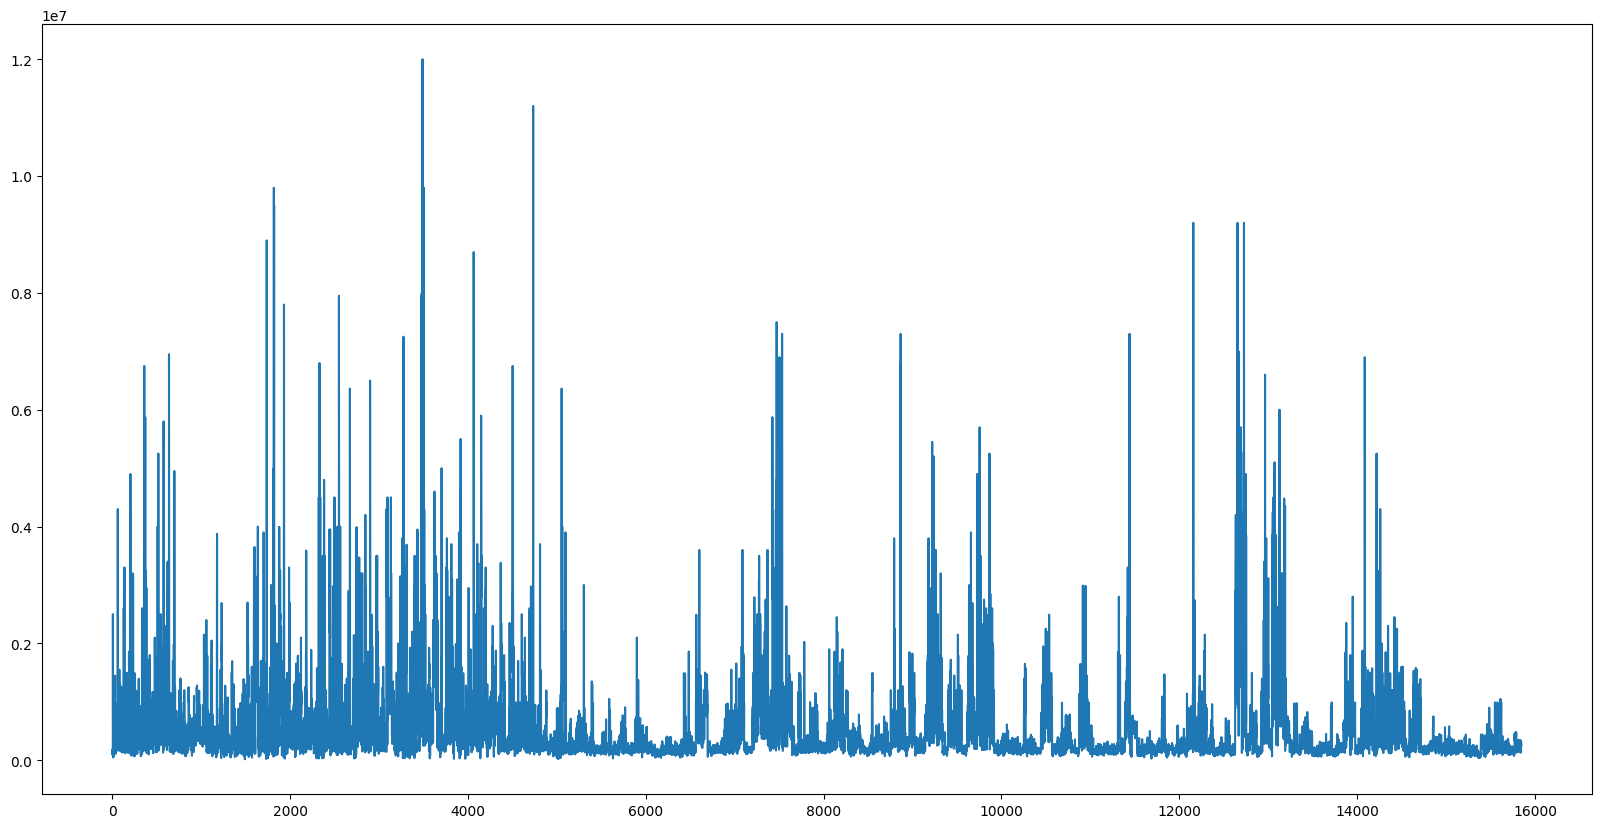

In [17]:
df_['price'].dropna().plot(figsize=(20, 10))

In [10]:
fig = px.box(df_.dropna(), x='rooms', y='price', facet_col='publisher')

fig.update_layout(title='Rooms vs Price', xaxis_title='Nº of rooms', yaxis_title='Price')

fig.show()

In [ ]:
fig = px.box(df_.dropna(), x='rooms', y='price', facet_col='publisher')

fig.update_layout(title='Rooms vs Price', xaxis_title='Nº of rooms', yaxis_title='Price')

fig.show()

In [37]:
heatmap_ = fl.Map(location=[36.9592884,-6.5695077], zoom_start=5)
HeatMap(df_[['lat', 'lng', 'price']].dropna()).add_to(heatmap_)

heatmap_

# heatmap_.save("heatmap_by_prices.html")

In [50]:
# Mapa con todas las ubicaciones de las viviendas (quitando nans)
# Cuesta ejecutarlo
map = fl.Map(location=[36.9592884,-6.5695077], zoom_start=5)

for loc in [(x, y) for x, y in zip(df_['lat'].dropna(), df_['lng'].dropna())]:
    fl.Marker(loc).add_to(map)
    
map

# heatmap_.save("locations_map.html")